<a href="https://colab.research.google.com/github/andreea003/beta-version/blob/main/Alzheimer_ViT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!unzip 'ADNI.zip' -d '/content/Data/'
# !unzip '/content/drive/MyDrive/generated_augmented.zip' -d '/content/Data/'

Archive:  ADNI.zip
   creating: /content/Data/ADNI/AD/
  inflating: /content/Data/ADNI/AD/1.png  
  inflating: /content/Data/ADNI/AD/10.png  
  inflating: /content/Data/ADNI/AD/11.png  
  inflating: /content/Data/ADNI/AD/12.png  
  inflating: /content/Data/ADNI/AD/13.png  
  inflating: /content/Data/ADNI/AD/14.png  
  inflating: /content/Data/ADNI/AD/15.png  
  inflating: /content/Data/ADNI/AD/16.png  
  inflating: /content/Data/ADNI/AD/17.png  
  inflating: /content/Data/ADNI/AD/18.png  
  inflating: /content/Data/ADNI/AD/19.png  
  inflating: /content/Data/ADNI/AD/2.png  
  inflating: /content/Data/ADNI/AD/20.png  
  inflating: /content/Data/ADNI/AD/21.png  
  inflating: /content/Data/ADNI/AD/22.png  
  inflating: /content/Data/ADNI/AD/23.png  
  inflating: /content/Data/ADNI/AD/24.png  
  inflating: /content/Data/ADNI/AD/25.png  
  inflating: /content/Data/ADNI/AD/26.png  
  inflating: /content/Data/ADNI/AD/27.png  
  inflating: /content/Data/ADNI/AD/28.png  
  inflating: /content/D

In [ ]:
!mkdir '/content/Data/checkpoint'

In [ ]:
import cv2
import matplotlib.pyplot as plt
import glob
import tqdm
from itertools import repeat

PATH = '/content/Data/'
ORIG_PATH = '/content/Data/ADNI/'
# GEN_PATH = '/content/Data/generated_augmented/'

In [ ]:
import glob
import cv2
import numpy as np
import tqdm
from sklearn.model_selection import train_test_split

# Define the target image size (e.g., 224x224 for ViT-B/32)
target_image_size = (224, 224)

# Initialize empty lists for data and labels
y = []
z = []

# Load images and labels from subdirectories within ORIG_PATH
for subdirectory in ['AD', 'HC', 'MCI']:  # List of subdirectory names
    subdirectory_path = ORIG_PATH + subdirectory + '/'
    image_files = glob.glob(subdirectory_path + '*')

    if not image_files:
        print(f"No images found in {subdirectory_path}")
        continue

    for img in tqdm.tqdm(image_files, desc=f'Loading {subdirectory}'):
        img_data = cv2.imread(img)
        if img_data is not None:
            # Resize the image to the target size
            img_data = cv2.resize(img_data, target_image_size)
            z.append(img_data)
            y.append(subdirectory)  # Use the subdirectory name as the label

# Split data into training and testing sets (e.g., 80% training, 20% testing)
x_train, x_test, y_train, y_test = train_test_split(z, y, test_size=0.2, random_state=42)

# Print shapes of the training and testing sets
print("Train", np.array(x_train).shape)
print("Train", np.array(y_train).shape)
np.save(PATH + 'x_train.npy', np.array(x_train))
np.save(PATH + 'y_train.npy', np.array(y_train))

print("Test", np.array(x_test).shape)
print("Test", np.array(y_test).shape)
np.save(PATH + 'x_test.npy', np.array(x_test))
np.save(PATH + 'y_test.npy', np.array(y_test))


Loading MCI: 100%|██████████| 30/30 [00:00<00:00, 458.75it/s]


Train (72, 224, 224, 3)
Train (72,)
Test (18, 224, 224, 3)
Test (18,)


**PREPROCESSING**

**VIT TRAINING**

In [ ]:
!pip install tensorflow-addons

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 612.1/612.1 kB 7.3 MB/s eta 0:00:00


**VIT TRAINED ON ORIGINAL DATASET**

In [ ]:
from PIL import Image

# Load an example image
image = Image.open("/content/Data/ADNI/AD/5.png")  # Replace "example.jpg" with your image file path

# Get image dimensions
width, height = image.size
channels = 3  # Assuming it's an RGB image

# Set the input shape
input_shape = (height, width, channels)
print("Input shape:", input_shape)


Input shape: (256, 170, 3)


In [1]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow_addons as tfa
from sklearn.model_selection import train_test_split
from sklearn import preprocessing

num_classes = 3
input_shape = (224, 224, 3)

x_train,y_train = np.load(PATH+'x_train.npy'), np.load(PATH+'y_train.npy')
label_encoder = preprocessing.LabelEncoder()
y_train = label_encoder.fit_transform(y_train)
print(x_train.shape,y_train.shape)

x_test,y_test = np.load(PATH+'x_test.npy'), np.load(PATH+'y_test.npy')
label_encoder = preprocessing.LabelEncoder()
y_test = label_encoder.fit_transform(y_test)
print(x_test.shape,y_test.shape)

X = np.concatenate((x_train,x_test),axis=0)
y = np.concatenate((y_train,y_test),axis=0)
x_train, x_test, y_train, y_test = train_test_split(X,y,test_size=0.1)

print(f"x_train shape: {x_train.shape} - y_train shape: {y_train.shape}")
print(f"x_test shape: {x_test.shape} - y_test shape: {y_test.shape}")

learning_rate = 0.001
weight_decay = 0.0001
batch_size = 256
num_epochs = 100
image_size = 72  # We'll resize input images to this size
patch_size = 6   # Size of the patches to be extract from the input images
num_patches = (image_size // patch_size) ** 2
projection_dim = 64
num_heads = 4
transformer_units = [
    projection_dim * 2,
    projection_dim,
]  # Size of the transformer layers
transformer_layers = 8
mlp_head_units = [2048, 1024]  # Size of the dense layers of the final classifier

data_augmentation = keras.Sequential(
    [
        layers.Normalization(),
        layers.Resizing(image_size, image_size),
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(factor=0.02),
        layers.RandomZoom(
            height_factor=0.2, width_factor=0.2
        ),
    ],
    name="data_augmentation",
)
# Compute the mean and the variance of the training data for normalization.
data_augmentation.layers[0].adapt(x_train)

def mlp(x, hidden_units, dropout_rate):
    for units in hidden_units:
        x = layers.Dense(units, activation=tf.nn.gelu)(x)
        x = layers.Dropout(dropout_rate)(x)
    return x

class Patches(layers.Layer):
    def __init__(self, patch_size):
        super().__init__()
        self.patch_size = patch_size

    def call(self, images):
        batch_size = tf.shape(images)[0]
        patches = tf.image.extract_patches(
            images=images,
            sizes=[1, self.patch_size, self.patch_size, 1],
            strides=[1, self.patch_size, self.patch_size, 1],
            rates=[1, 1, 1, 1],
            padding="VALID",
        )
        patch_dims = patches.shape[-1]
        patches = tf.reshape(patches, [batch_size, -1, patch_dims])
        return patches

import matplotlib.pyplot as plt

plt.figure(figsize=(4, 4))
image = x_train[np.random.choice(range(x_train.shape[0]))]
plt.imshow(image.astype("uint8"))
plt.axis("off")

resized_image = tf.image.resize(
    tf.convert_to_tensor([image]), size=(image_size, image_size)
)
patches = Patches(patch_size)(resized_image)
print(f"Image size: {image_size} X {image_size}")
print(f"Patch size: {patch_size} X {patch_size}")
print(f"Patches per image: {patches.shape[1]}")
print(f"Elements per patch: {patches.shape[-1]}")

n = int(np.sqrt(patches.shape[1]))
plt.figure(figsize=(4, 4))
for i, patch in enumerate(patches[0]):
    ax = plt.subplot(n, n, i + 1)
    patch_img = tf.reshape(patch, (patch_size, patch_size, 3))
    plt.imshow(patch_img.numpy().astype("uint8"))
    plt.axis("off")

class PatchEncoder(layers.Layer):
    def __init__(self, num_patches, projection_dim):
        super().__init__()
        self.num_patches = num_patches
        self.projection = layers.Dense(units=projection_dim)
        self.position_embedding = layers.Embedding(
            input_dim=num_patches, output_dim=projection_dim
        )

    def call(self, patch):
        positions = tf.range(start=0, limit=self.num_patches, delta=1)
        encoded = self.projection(patch) + self.position_embedding(positions)
        return encoded

def create_vit_classifier():
    inputs = layers.Input(shape=input_shape)
    # Augment data.
    augmented = data_augmentation(inputs)
    # Create patches.
    patches = Patches(patch_size)(augmented)
    # Encode patches.
    encoded_patches = PatchEncoder(num_patches, projection_dim)(patches)

    # Create multiple layers of the Transformer block.
    for _ in range(transformer_layers):
        # Layer normalization 1.
        x1 = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
        # Create a multi-head attention layer.
        attention_output = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=projection_dim, dropout=0.1
        )(x1, x1)
        # Skip connection 1.
        x2 = layers.Add()([attention_output, encoded_patches])
        # Layer normalization 2.
        x3 = layers.LayerNormalization(epsilon=1e-6)(x2)
        # MLP.
        x3 = mlp(x3, hidden_units=transformer_units, dropout_rate=0.1)
        # Skip connection 2.
        encoded_patches = layers.Add()([x3, x2])

    # Create a [batch_size, projection_dim] tensor.
    representation = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
    representation = layers.Flatten()(representation)
    representation = layers.Dropout(0.5)(representation)
    # Add MLP.
    features = mlp(representation, hidden_units=mlp_head_units, dropout_rate=0.5)
    # Classify outputs.
    logits = layers.Dense(num_classes)(features)
    # Create the Keras model.
    model = keras.Model(inputs=inputs, outputs=logits)
    return model

def run_experiment(model):
    optimizer = tfa.optimizers.AdamW(
        learning_rate=learning_rate, weight_decay=weight_decay
    )

    model.compile(
        optimizer=optimizer,
        loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
        metrics=[
            keras.metrics.SparseCategoricalAccuracy(name="accuracy"),
            keras.metrics.SparseTopKCategoricalAccuracy(5, name="top-5-accuracy"),
        ],
    )

    checkpoint_filepath = PATH+"/checkpoint/checkpoint"
    checkpoint_callback = keras.callbacks.ModelCheckpoint(
        checkpoint_filepath,
        monitor="val_accuracy",
        save_best_only=True,
        save_weights_only=True,
    )

    earlyStoppingCallback = keras.callbacks.EarlyStopping(patience=120, monitor='val_accuracy', restore_best_weights=True)

    history = model.fit(
        x=x_train,
        y=y_train,
        batch_size=batch_size,
        epochs=num_epochs,
        validation_split=0.1,
        callbacks=[checkpoint_callback, earlyStoppingCallback],
    )

    model.load_weights(checkpoint_filepath)
    _, accuracy, top_5_accuracy = model.evaluate(x_test, y_test)
    print(f"Test accuracy: {round(accuracy * 100, 2)}%")
    print(f"Test top 5 accuracy: {round(top_5_accuracy * 100, 2)}%")

    return history


vit_classifier = create_vit_classifier()
history = run_experiment(vit_classifier)


ModuleNotFoundError: No module named 'tensorflow_addons'

In [ ]:
import json
history_dict = history.history
json.dump(history_dict, open('/content/Data/checkpoint/history_generated', 'w'))

1/1 [==============================] - 2s 2s/step

Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         3
           1       1.00      0.75      0.86         4
           2       0.67      1.00      0.80         2

    accuracy                           0.89         9
   macro avg       0.89      0.92      0.89         9
weighted avg       0.93      0.89      0.89         9

[[3 0 0]
 [0 3 1]
 [0 0 2]]


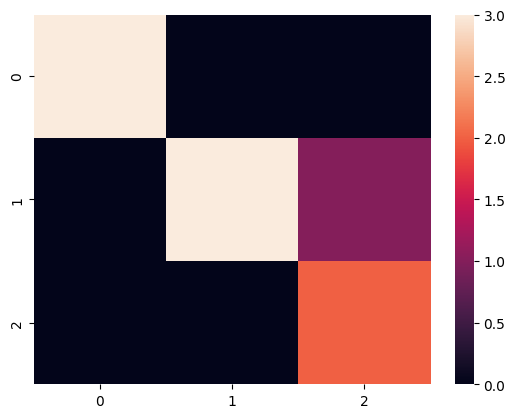

In [ ]:
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix, roc_curve, roc_auc_score, RocCurveDisplay, auc
import seaborn as sns
y_predict = vit_classifier.predict(x_test)
y_pred = np.argmax(np.round(y_predict), axis=1)
sns.heatmap(confusion_matrix(y_test, y_pred))
print('\nClassification Report:\n', classification_report(y_test, y_pred))
confusion_matrix_graph = confusion_matrix(y_test, y_pred)
print(confusion_matrix_graph)